### Contact on balls inside strike zone

Seasons 12-14:
```python
df["ruth"] = (df["pitcher_ruthlessness"]
              * (1 + 0.2*df["pitcher_vibes"])
              * df["pitcher_multiplier"])

df["combined_batting"] = (1/2) * (
    df["batter_divinity"] * df["batter_multiplier"]
    + df["batter_musclitude"] * df["batter_multiplier"]
    + df["batter_thwackability"] * df["batter_multiplier"]
    - df["batter_patheticism"] / df["batter_multiplier"]
) * (1 + 0.2 * df["batter_vibes"])

dfc["combined_batting_1.2"] = (dfc["combined_batting"])**(1.2)

dfc["ballpark_sum"] = (dfc["fort_center"]+ 3*dfc["visc_center"] - 6*dfc["fwd_center"]) / 10

dfc["threshold"] = (
    0.8
    - 0.08*dfc["ruth"]
    + 0.16*dfc["ballpark_sum"]
    + 0.16*dfc["combined_batting_1.2"]
)
dfc.loc[(dfc["threshold"] > 0.9), "threshold"] = 0.9
```

Season 15:
```python
# other definitions same as above
dfc["threshold"] = (
    0.78
    - 0.08*dfc["ruth"]
    + 0.16*dfc["ballpark_sum"]
    + 0.17*dfc["combined_batting_1.2"]
)
dfc["threshold_plot"] = dfc["threshold"].copy()

dfc.loc[(dfc["threshold"] > 0.925), "threshold"] = 0.925
```

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

import load

In [67]:
# season = [11, 12, 13, 14, 15, 16, 17]
season = 18

df = load.data("contact", season=season)

df = df[df["is_strike"] == True]

df["ruth"] = load.player_attribute(df, 'pitcher', 'ruthlessness', vibes=True, mods=True, items=True, broken_items=True)
df["cold_vibes"] = load.player_attribute(df, 'pitcher', 'coldness', vibes=True, mods=True, items=True, broken_items=True)

df["div_vibes"] = load.player_attribute(df, 'batter', 'divinity', vibes=True, mods=True, items=True, broken_items=True)
df["musc_vibes"] = load.player_attribute(df, 'batter', 'musclitude', vibes=True, mods=True, items=True, broken_items=True)
df["thwack_vibes"] = load.player_attribute(df, 'batter', 'thwackability', vibes=True, mods=True, items=True, broken_items=True)
df["path_scaled"] = load.player_attribute(df, 'batter', 'patheticism', vibes=False, mods="negative", items="negative", broken_items=True)
df["path_vibes"] = df["path_scaled"] * (1 + 0.2 * df["batter_vibes"])


# center=True is the default
df["fortification"] = load.stadium_attribute(df, 'fortification', center=True)
df["forwardness"] = load.stadium_attribute(df, 'forwardness', center=True)
df["viscosity"] = load.stadium_attribute(df, 'viscosity', center=True)


print(len(df))

# all_files = glob.glob("../roll_data/*-contact.csv")
# print(all_files)

# df = pd.concat((pd.read_csv(f, dtype={"stadium_id": "string", "is_strike": "boolean"}) for f in all_files),
#                ignore_index=True)

# seasons = [11, 12, 13, 14]
# # seasons = [11, 12, 13]
# # seasons = [13]
# # seasons = [14]
# df = df[df['season'].isin(seasons)]
# len(df)

81377


In [142]:
# df.loc[df["pitcher_mods"].astype(str).str.contains("SCATTERED"), "pitcher_vibes"] = 0
# df.loc[df["batter_mods"].astype(str).str.contains("SCATTERED"), "batter_vibes"] = 0
# df.loc[df["fielder_mods"].astype(str).str.contains("SCATTERED"), "fielder_vibes"] = 0

# df["ruth"] = df["pitcher_ruthlessness"] * (1 + 0.2*df["pitcher_vibes"]) * df["pitcher_multiplier"]
# df["ruth"] = df["ruth_vibes"]
# df["combined_batting"] = (1/2) * (
#     df["batter_divinity"] * df["batter_multiplier"]
#     + df["batter_musclitude"] * df["batter_multiplier"]
#     + df["batter_thwackability"] * df["batter_multiplier"]
#     - df["batter_patheticism"] / df["batter_multiplier"]
# ) * (1 + 0.2 * df["batter_vibes"])

df["combined_batting"] = 0.5 * (
    df["div_vibes"] + df["musc_vibes"] + df["thwack_vibes"] - df["path_vibes"]
)

df["hypediff"] = df["batting_team_hype"] - df["pitching_team_hype"]
df["hypediff_pvibes"] = df["hypediff"] * (1 + 0.2 * df["pitcher_vibes"])
df["hypediff_bvibes"] = df["hypediff"] * (1 + 0.2 * df["batter_vibes"])
df["combined_batting_hype"] = df["combined_batting"] + df["hypediff_bvibes"]

In [395]:
dfc = df.copy()
dfc = dfc[dfc["is_strike"] == True]

dfc = dfc[~((dfc["season"] == 11) & (dfc["day"] == 98))] # bad data here

# for exclude_mod in ["GROWTH", "TRAVELING", "SHELLED", "CHUNKY", "SMOOTH", "ON_FIRE", "LATE_TO_PARTY"]:
for exclude_mod in ["LATE_TO_PARTY", "ON_FIRE", "CHUNKY", "SMOOTH", "GROWTH", "MINIMALIST", "MAXIMALIST",
                    "SINKING_SHIP", "TRAVELING", "HIGH_PRESSURE", "OVERPERFORMING", "UNDERPERFORMING", "AFFINITY_FOR_CROWS",]:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    # dfc = dfc[~dfc["fielder_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]

dfc = dfc[~(dfc["batting_team_mods"].astype(str).str.contains("O_NO") & (dfc["ball_count"] == 0))]
# dfc = dfc[(dfc["pitcher_multiplier"] == 1) & (dfc["batter_multiplier"] == 1)]
dfc_bad = dfc[dfc["combined_batting_hype"] < 0].copy()
dfc = dfc[dfc["combined_batting_hype"] >= 0]
# dfc = dfc[dfc["hypediff"] == 0]

len(dfc)

28055

In [396]:
# hall of shame
dfc_bad.groupby("batter_name").size()

batter_name
Anathema Elemefayo     17
Andrew Solis           18
Basilio Fig            16
Bevan Wise              6
Bobbin Moss            19
Bonk Jokes             15
Brisket Friendo        31
Caleb Novak            84
Cory Ross               3
Dervin Gorczyca         1
Elwin McGhee           11
Erin Jesaulenko        27
Evelton McBlase II     13
Farrell Seagull        20
Freemium Seraph        21
Halexandrey Walton      4
Jasper Blather          4
Jessi Wise              2
Jomgy Rolsenthal        9
Kathy Mathews           2
Matteo Prestige         4
Millipede Aqualuft     23
Muse Scantron          14
Nickname Yamashita     34
Ogden Mendoza           2
Oliver Notarobot        5
Qais Dogwalker         13
Rylan O'Lantern        50
S--w Bri--s             1
Sandie Turner           9
Scarlet Caster         31
Sexton Wheerer         14
Silvaire Semiquaver    22
Socks Maybe             5
Sosa Elftower           1
Stephanie Winters      25
Stew Briggs            39
Tai Beanbag            28


In [397]:
dfc.loc[dfc["passed"], "roll"].max()

0.9249565435747312

In [478]:
powers = ["0.1", "0.2", "0.3", "0.4",
          "0.5", "0.55", "0.6", "0.65", "0.7", "0.75", "0.8", "0.85", "0.9", "0.95",
    "1.0", "1.05", "1.1", "1.15", "1.2", "1.25", "1.3", "1.35", "1.4", "1.45", "1.5",
          "1.6", "1.7", "1.8", "1.9", "2.0", "2.1", "2.2", "2.3", "2.4", "2.5",
          "2.6", "2.7", "2.8", "2.9", "3.0"]
for pow in powers:
    dfc["combined_batting_"+pow] = (dfc["combined_batting"] + 0*dfc["hypediff_bvibes"]) ** float(pow)

# dfc["grand_center"] = dfc["ballpark_grandiosity"] - 0.5
# dfc["fort_center"] = dfc["ballpark_fortification"] - 0.5
# dfc["obt_center"] = dfc["ballpark_obtuseness"] - 0.5
# dfc["om_center"] = dfc["ballpark_ominousness"] - 0.5
# dfc["inc_center"] = dfc["ballpark_inconvenience"] - 0.5
# dfc["visc_center"] = dfc["ballpark_viscosity"] - 0.5
# dfc["fwd_center"] = dfc["ballpark_forwardness"] - 0.5
# dfc["myst_center"] = dfc["ballpark_mysticism"] - 0.5
# dfc["elong_center"] = dfc["ballpark_elongation"] - 0.5

# dfc["ballpark_sum"] = (dfc["fort_center"] + 3*dfc["visc_center"] - 6*dfc["fwd_center"]) / 10
dfc["ballpark_sum"] = (dfc["fortification"] + 3*dfc["viscosity"] - 6*dfc["forwardness"]) / 10

dfc["hypediff"] = dfc["batting_team_hype"] - dfc["pitching_team_hype"]
dfc["hypediff_pvibes"] = dfc["hypediff"] * (1 + 0.2 * dfc["pitcher_vibes"])
dfc["hypediff_bvibes"] = dfc["hypediff"] * (1 + 0.2 * dfc["batter_vibes"])

# dfc["combined_batting_1.1"] = (dfc["combined_batting"] + dfc["hypediff_pvibes"])**(1.1)
# dfc["combined_batting_1.2"] = (dfc["combined_batting"] + dfc["hypediff_pvibes"])**(1.2)
# dfc["combined_batting_1.25"] = (dfc["combined_batting"] + dfc["hypediff_pvibes"])**(1.25)
# dfc["combined_batting_1.3"] = (dfc["combined_batting"] + dfc["hypediff_pvibes"])**(1.3)

dfc["ruth_hype"] = dfc["ruth"] - 0.2 * dfc["hypediff_pvibes"]
# we know the intercept is 0.4 in s12/s13 and 0.35 in s14/s15 so special case it here so the fit works across
# dfc.loc[dfc["season"] == 13,"roll"] -= 0.05
# dfc.loc[dfc["season"] == 14,"roll"] -= 0.05
dfc = dfc[~dfc["combined_batting_0.5"].isna()]

In [479]:
# dfc_bad = dfc[dfc["batter_name"].isin(hall_of_shame)].copy()
# dfc_good = dfc[~dfc["batter_name"].isin(hall_of_shame)].copy()

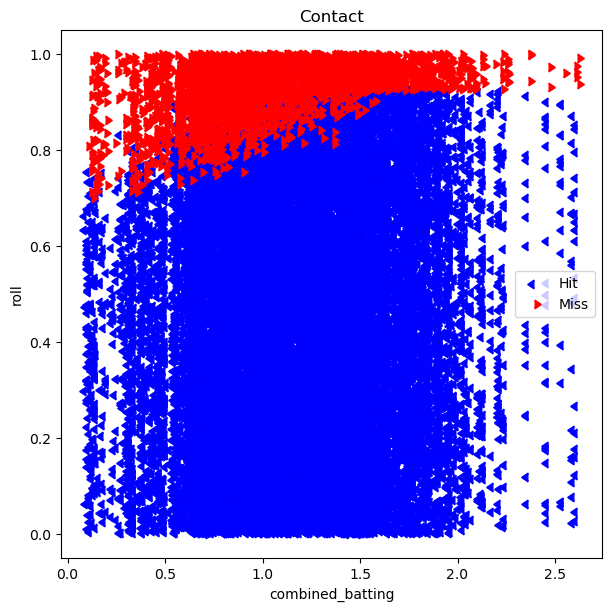

In [480]:
x_val = "combined_batting"
y_val = "roll"
fig, ax = plt.subplots(1, figsize=(6, 6), layout="constrained")
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]][y_val],
    color="blue",
    label="Hit",
    marker=CARETLEFTBASE,
)
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]][y_val],
    color="red",
    label="Miss",
    marker=CARETRIGHTBASE,
)



ax.set_xlabel(x_val)
ax.set_ylabel("roll")
ax.set_title(f"Contact")
# ax.set_ylim(0.6, 1)

if x_val == "threshold":
    ax.plot(ax.get_xlim(), ax.get_xlim())

ax.legend()

In [481]:
X = dfc[
    [
        "roll",
        "season",
        "passed",
        "ruth",
        # "ruth_hype",
        # "combined_batting_1.5",
        # "combined_batting",
        # "combined_batting_0.5",
        # "combined_batting_1.2",
        "combined_batting_1.15",

        "ballpark_sum",
        "hypediff_bvibes",
        "hypediff_pvibes",
    ]
].copy()
# X = X[~X["combined_batting_1.2"].isna()]
X = X[X['roll'] < 0.925]
y = X["passed"]
X = X.drop(["passed", "season"], axis=1)

pin_intercept = None
pin_intercept = 0.78
pins = [
    (-0.08, "ruth"),
    (0.16, "ballpark_sum"),
    (0.17, "combined_batting_1.15")
]
for val, var in pins:
    X["roll"] -= X[var] * val
    X = X.drop(var, axis=1)

sc = StandardScaler(with_mean=False)
X2 = sc.fit_transform(X)
if pin_intercept is not None:
    X2[:, 0] -= pin_intercept / sc.scale_[0]
    
print(X.shape)

trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=10000000, fit_intercept=pin_intercept is None,
                           tol=1e-10).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))
sc.inverse_transform(trainedsvm.coef_)
trainedsvm.coef_
sc.scale_
trainedsvm.score(X2, y)
print(f"score: {trainedsvm.score(X2, y)} ({len(X2) - sum(np.diag(confusion_matrix(y, predictionsvm)))} outliers)")

coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]
intercept = trainedsvm.intercept_  # - np.dot(coef, sc.mean_)
intercept_scaled = -(intercept / coef[0, 0])[0] if pin_intercept is None else pin_intercept

print(intercept_scaled, ", intercept")
for pair in pins + list(zip(-np.array(coef_list), X.columns)):
    if "roll" not in pair[1]:
        print(pair)

(25926, 3)
[[ 1184    12]
 [    5 24725]]
              precision    recall  f1-score   support

       False       1.00      0.99      0.99      1196
        True       1.00      1.00      1.00     24730

    accuracy                           1.00     25926
   macro avg       1.00      0.99      1.00     25926
weighted avg       1.00      1.00      1.00     25926

score: 0.9993442875877497 (17 outliers)
0.78 , intercept
(-0.08, 'ruth')
(0.16, 'ballpark_sum')
(0.17, 'combined_batting_1.15')
(0.074759992621053, 'hypediff_bvibes')
(0.019681609842257634, 'hypediff_pvibes')


In [482]:
dfc["threshold"] = intercept_scaled
print("intercept:", intercept_scaled)
for pair in pins + list(zip(-np.array(coef_list), X.columns)):
    if pair[1] != "roll":
        print(pair)
        dfc["threshold"] += pair[0] * dfc[pair[1]]
dfc["threshold_plot"] = dfc["threshold"]
dfc.loc[dfc["threshold"] > 0.925, "threshold"] = 0.925
# def fit_func_cap(row):
#     season = row["season"]
#     if season in [11, 12, 13]:
#         threshold = min(0.9, 
#             0.80
#             - 0.08*row["ruth"]
#             + 0.16*row["ballpark_sum"]
#             + 0.16*row["combined_batting_1.2"]
#         )
#     elif season >= 14:
#         threshold = min(0.925,
#             0.78
#             - 0.08*row["ruth"]
#             + 0.16*row["ballpark_sum"]
#             + 0.17*row["combined_batting_1.2"]
#         )
#     return threshold

# def fit_func(row):
#     season = row["season"]
#     if season in [11, 12, 13]:
#         threshold = (
#             0.80
#             - 0.08*row["ruth"]
#             + 0.16*row["ballpark_sum"]
#             + 0.16*row["combined_batting_1.2"]
#         )
#     elif season >= 14:
#         threshold = (
#             0.78
#             - 0.08*row["ruth"]
#             + 0.16*row["ballpark_sum"]
#             + 0.17*row["combined_batting_1.2"]
#         )
#     return threshold

# dfc["threshold_plot"] = dfc.apply(fit_func, axis=1)
# dfc["threshold"] = dfc.apply(fit_func_cap, axis=1)

intercept: 0.78
(-0.08, 'ruth')
(0.16, 'ballpark_sum')
(0.17, 'combined_batting_1.15')
(0.074759992621053, 'hypediff_bvibes')
(0.019681609842257634, 'hypediff_pvibes')


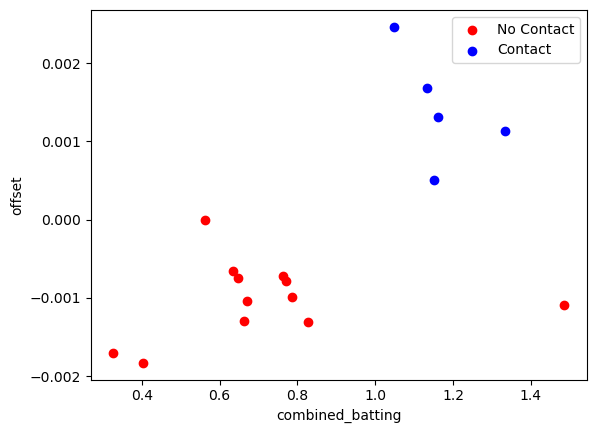

In [483]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]

fig, ax = plt.subplots(1)
x_val = "threshold_plot"
x_val = "combined_batting"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["offset"],
    color="red",
    label="No Contact",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Contact",
)
ax.set_xlabel(x_val)
ax.set_ylabel("offset")
ax.legend()

In [438]:
pd.set_option("display.max_columns", None)
table = outliers[
    [
        "passed",
        "offset",
        # "event_type",
        # "weather",
        # "batter_laserlikeness",
        "roll",
        "threshold",
        "ruth",
        "combined_batting",
        # "combined_batting",
        # "combined_batting_0.5",
        # "combined_batting_1.25",
        # "combined_batting_0.25",
        # "pitcher_multiplier",
        # "batter_multiplier",
        "hypediff_bvibes",
        "batter_name",
        "pitcher_name",
        "batter_mods",
        "pitcher_mods",
        "batting_team_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
        # "fielder_roll",
        "weather",
        "top_of_inning",
        # "ball_count",
        # "strike_count",
        # "out_count",
        # "baserunner_count",
    ]
]
print(len(table))
table.sort_values("offset", ascending=False)

17


,passed,offset,roll,threshold,ruth,combined_batting,hypediff_bvibes,batter_name,pitcher_name,batter_mods,pitcher_mods,batting_team_mods,pitching_team_mods,season,day,game_id,play_count,weather,top_of_inning
93519,True,0.002411,0.920250,0.917839,0.777201,1.047916,0.465921,Mullen Peterson,Silvia Winner,CAREFUL;REPEATING,,BIRD_SEED,LOVE,18,48,3a7c8b64-a98f-4986-b376-11eda100d298,152,Weather.BLOODDRAIN,False
37412,True,0.001697,0.896718,0.895021,1.123123,1.134211,0.142832,Mooney Doctor II,Betsy Trombone,FRIEND_OF_CROWS;ALTERNATE;FIREPROOF,FRIEND_OF_CROWS;ALTERNATE,FIREPROOF,HOME_FIELD;SHAME_GIVER,18,72,ccafc5fd-1e75-47e8-834f-770a74437cc0,318,Weather.BLACK_HOLE,False
90755,True,0.001312,0.883096,0.881784,1.133021,1.160525,0.000000,Cory Ross,Mohammed Picklestein,SIPHON,,POPCORN_PAYOUTS,PSYCHIC,18,46,31776b29-4804-46ac-97d0-bc1c4bc17e68,51,Weather.BLOODDRAIN,False
26283,True,0.001192,0.904514,0.903322,1.428166,1.333941,0.170242,Peanutiel Duffy,Jayden Wright,HONEY_ROASTED,,,BASE_INSTINCTS,18,17,fe1e599d-8570-4b41-a003-76393712945d,283,Weather.SUN_2,False
12255,True,0.000512,0.900225,0.899713,0.762190,1.151093,0.000000,Lotus Mango,Adalberto Tosser,NEGATIVE,CREDIT_TO_THE_TEAM;WILD,SHAME_GIVER,0;UNHOLEY;CARCINIZATION,18,6,3eca069e-57ef-47e0-95d4-8bbe77efa31c,174,Weather.BLOODDRAIN,False
49474,False,-0.000039,0.820435,0.820473,0.418583,0.561992,-0.240000,Zippy DeShields,Axel Cardenas,SOUNDPROOF;SCATTERED,EXTRA_STRIKE,GRAVITY;SOUNDPROOF,FIREPROOF;SOUNDPROOF,18,82,0e0ecce3-a19c-4ed8-ba1c-2ff2b49a87ed,219,Weather.FEEDBACK,True
49791,False,-0.000619,0.864645,0.865264,0.780989,0.761801,0.676476,Muse Scantron,Grollis Zephyr,,,BLACKHOLE_PAYOUTS;BOTTOM_DWELLER,FIREPROOF;POPCORN_PAYOUTS,18,82,01275abd-4e9c-4ec5-b9a5-fa2f7a0f3706,368,Weather.BLACK_HOLE,False
81966,False,-0.000650,0.787766,0.788416,0.986470,0.635359,0.000000,Stephanie Winters,Howell Rocha,,,,LIFE_OF_PARTY;ELECTRIC,18,39,bf040bcd-46de-484a-9337-5797356a22be,42,Weather.SUN_2,True
77925,False,-0.000743,0.800850,0.801593,0.911897,0.647847,0.000000,Trinity Smaht,Leach Herman,,FRIEND_OF_CROWS;ALTERNATE,0;UNHOLEY;CARCINIZATION,AAA,18,35,da215672-e07f-4daf-b203-0524afd80968,281,Weather.FLOODING,False
7055,False,-0.000781,0.833400,0.834182,0.815277,0.769486,0.000000,Farrell Seagull,King Weatherman,UNCERTAIN,TRIPLE_THREAT,BLACKHOLE_PAYOUTS;BOTTOM_DWELLER,O_NO,18,68,23935f9d-149f-43ee-bbbf-840297a1caa2,78,Weather.BLOODDRAIN,True


In [439]:
# print("batter items:")
# for batter in outliers.loc[:, "batter_object"]:
#     print(batter.items, "\n")

# print("pitcher items:")
# for pitcher in outliers.loc[:, "pitcher_object"]:
#     print(pitcher.items, "\n")

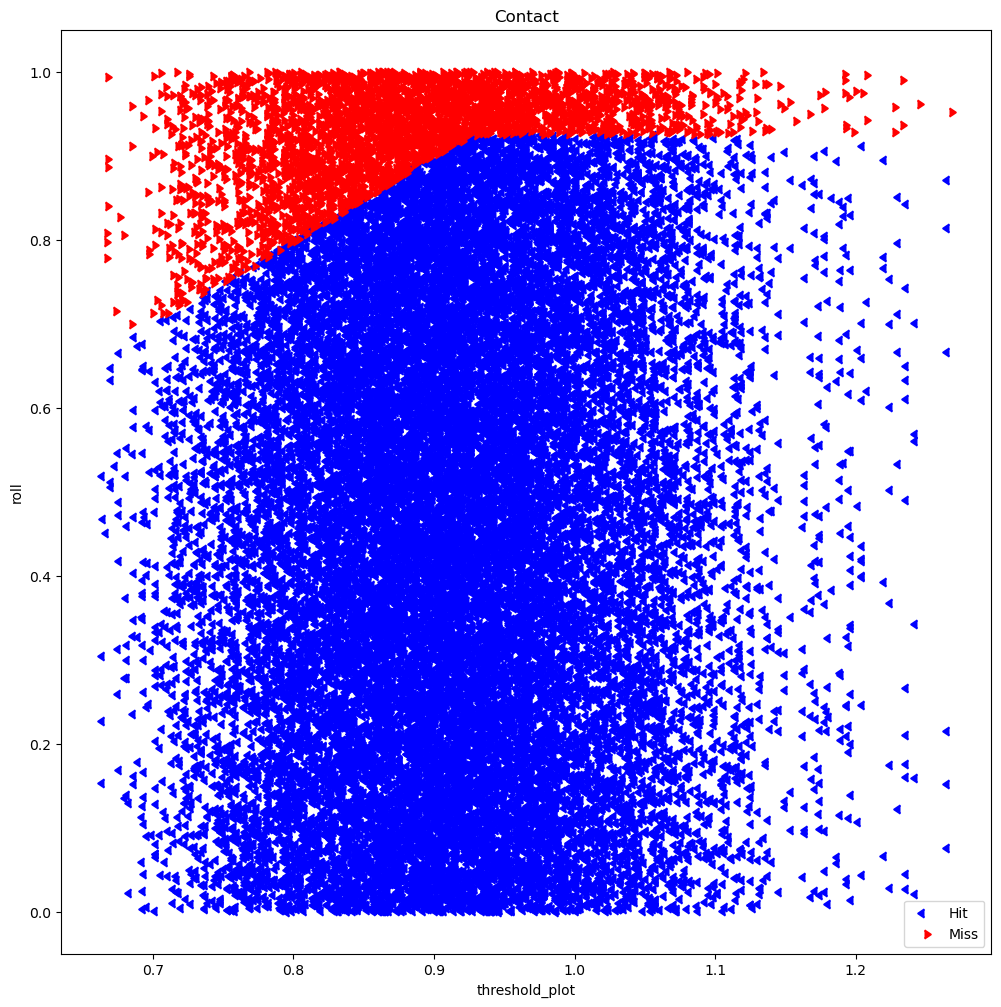

In [440]:
x_val = "threshold_plot"
# x_val = "combined_batting_1.2"
y_val = "roll"
fig, ax = plt.subplots(1, figsize=(12, 12))
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]][y_val],
    color="blue",
    label="Hit",
    marker=CARETLEFTBASE,
)
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]][y_val],
    color="red",
    label="Miss",
    marker=CARETRIGHTBASE,
)

ax.set_xlabel(x_val)
ax.set_ylabel("roll")
ax.set_title(f"Contact")
# ax.set_ylim(0.6, 1)

if x_val == "threshold":
    ax.plot(ax.get_xlim(), ax.get_xlim())

ax.legend(loc="lower right")
fig.savefig("../figures/contact_strikes_s19.png", facecolor="white")

In [441]:
# outliers_scatter = outliers.loc[:, [
#     "offset",
#     "batter_buoyancy",
#     "batter_divinity",
#     "batter_martyrdom",
#     "batter_moxie",
#     "batter_musclitude",
#     "batter_patheticism",
#     "batter_thwackability",
#     "batter_tragicness",
#     "batter_vibes",
#     "pitcher_ruthlessness",
#     "pitcher_overpowerment",
#     "pitcher_unthwackability",
#     "pitcher_shakespearianism",
#     "pitcher_suppression",
#     "pitcher_coldness",
#     "pitcher_vibes"
# ]].copy()

In [442]:
# scatter_matrix(outliers_scatter, alpha=0.2, figsize=(10, 10), diagonal="kde");

In [443]:
# for col in [
#     "batter_buoyancy",
#     "batter_divinity",
#     "batter_martyrdom",
#     "batter_moxie",
#     "batter_musclitude",
#     "batter_patheticism",
#     "batter_thwackability",
#     "batter_tragicness",
#     "batter_vibes",
#     "pitcher_ruthlessness",
#     "pitcher_overpowerment",
#     "pitcher_unthwackability",
#     "pitcher_shakespearianism",
#     "pitcher_suppression",
#     "pitcher_coldness",
#     "pitcher_vibes"
# ]:
#     plt.figure()
#     plt.plot(outliers_scatter[col], outliers_scatter["offset"],'o')
#     plt.xlabel(col)
#     plt.ylabel('offset')

## Grid Search

0.78 , intercept
(-0.08, 'ruth')
(0.16, 'ballpark_sum')
(0.17, 'combined_batting_pow')
(0.07568703751815965, 'hypediff_bvibes')
(0.018673769957856846, 'hypediff_pvibes')
0.9993458267595337
17
1.15


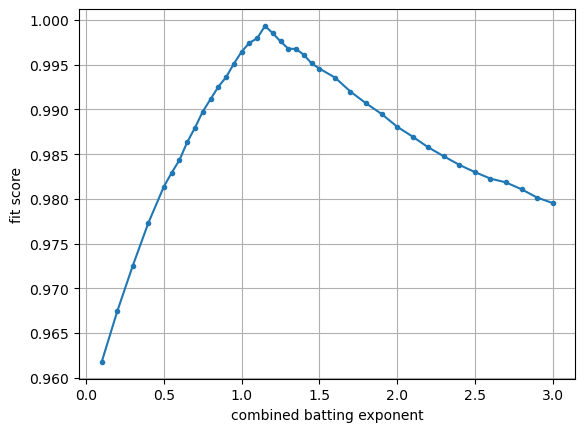

In [451]:
# powers = ["0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9",
#     "1.0", "1.1", "1.2", "1.3", "1.4", "1.5", "1.6", "1.7", "1.8", "1.9", "2.0",
#          "2.1", "2.2", "2.3", "2.4", "2.5", "2.6", "2.7", "2.8", "2.9", "3.0"]
powers = ["0.1", "0.2", "0.3", "0.4",
          "0.5", "0.55", "0.6", "0.65", "0.7", "0.75", "0.8", "0.85", "0.9", "0.95",
    "1.0", "1.05", "1.1", "1.15", "1.2", "1.25", "1.3", "1.35", "1.4", "1.45", "1.5",
          "1.6", "1.7", "1.8", "1.9", "2.0", "2.1", "2.2", "2.3", "2.4", "2.5",
          "2.6", "2.7", "2.8", "2.9", "3.0"]
scores = np.zeros(len(powers))
for i, pow1 in enumerate(powers):
    # print("=================================================")
    # print("musc_"+pow1, "mox_"+pow2)
    # print("=================================================")
    dfc["combined_batting_pow"] = dfc["combined_batting_"+pow1]

    X = dfc[[
    "roll",
    "season",
    "passed",
    "ruth",
    "combined_batting_pow",
    "ballpark_sum",
    "hypediff_bvibes",
    "hypediff_pvibes",
    ]].copy()
    X = X[~X["combined_batting_pow"].isna()]
    X = X[X['roll'] < 0.925]
    y = X["passed"]
    X = X.drop(["passed", "season"], axis=1)

    pin_intercept = None
    pin_intercept = 0.78
    pins = [
        (-0.08, "ruth"),
        (0.16, "ballpark_sum"),
        (0.17, "combined_batting_pow")
    ]
    for val, var in pins:
        X["roll"] -= X[var] * val
        X = X.drop(var, axis=1)

    sc = StandardScaler(with_mean=False)
    X2 = sc.fit_transform(X)
    if pin_intercept is not None:
        X2[:, 0] -= pin_intercept / sc.scale_[0]
    # print(X["roll"].max())
    # print(X.shape)

    trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=10000000, fit_intercept=pin_intercept is None,
                               tol=1e-10).fit(X2, y)
    predictionsvm = trainedsvm.predict(X2)
    # print(confusion_matrix(y, predictionsvm))
    sc.inverse_transform(trainedsvm.coef_)
    trainedsvm.coef_
    sc.scale_
    scores[i] = trainedsvm.score(X2, y)
    # print(scores[i])
    if i == 17:
        coef = np.true_divide(trainedsvm.coef_, sc.scale_)
        coef_scaled = coef / coef[0, 0]
        coef_list = coef_scaled.tolist()[0]
        intercept = trainedsvm.intercept_  # - np.dot(coef, sc.mean_)
        intercept_scaled = -(intercept / coef[0, 0])[0] if pin_intercept is None else pin_intercept

        print(intercept_scaled, ", intercept")
        for pair in pins + list(zip(-np.array(coef_list), X.columns)):
            if "roll" not in pair[1]:
                print(pair)
                pass

# print the last one, just for fun
# coef = np.true_divide(trainedsvm.coef_, sc.scale_)
# coef_scaled = coef / coef[0, 0]
# coef_list = coef_scaled.tolist()[0]
# intercept = trainedsvm.intercept_  # - np.dot(coef, sc.mean_)
# intercept_scaled = -(intercept / coef[0, 0])[0] if pin_intercept is None else pin_intercept
            
# print(intercept_scaled, ", intercept")
# for pair in pins + list(zip(-np.array(coef_list), X.columns)):
#     if "roll" not in pair[1]:
#         print(pair)
#         pass
xx = np.array([float(i) for i in powers])
plt.plot(xx, scores, '.-')
# plt.colorbar()
plt.xlabel("combined batting exponent")
plt.ylabel("fit score")
plt.grid()
print(scores.max())
print(scores.argmax())
print(xx[scores.argmax()])

In [445]:
print(scores.max())
print(scores.argmax())
print(xx[scores.argmax()])

0.9996536729903414
17
1.15


In [446]:
# with both
0.99943620944819
17
1.15

1.15

In [427]:
# without pvibes
0.9993422443562217
17
1.15

1.15

In [428]:
# without bvibes
0.9982616457985858
16
1.1

1.1

In [429]:
# without either
0.9863750616645917
19
1.25

1.25